# Hikaru Investigation Simulation

## Loading Dataset

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error,median_absolute_error
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
pd.options.mode.chained_assignment = None
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

In [92]:
df = pd.read_csv("Hikaru Big Simulation.csv")

In [93]:
df['ELO Difference'] = df['Hikaru ELO']-df['Anonymous GM ELO']

## Extra Functions

In [94]:
def rmse(mse):
    return mse**0.5

In [95]:
def get_scores(target, predictions):
    mse = round(mean_squared_error(target, predictions),3)
    mean_ae = round(mean_absolute_error(target,predictions),3)
    rmse = round(mean_squared_error(target, predictions)**0.5,3)
    median_ae = round(median_absolute_error(target,predictions),3)
    r2 = r2_score(target,predictions)
    return [mse,rmse,mean_ae,median_ae,r2]

In [96]:
def full_stats(data):
    mean = data.mean()
    median = data.quantile(0.50)
    minimum = data.min()
    maximum = data.max()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3-q1
    big_outliers = q3 + (1.5*iqr)
    small_outliers = q1 - (1.5*iqr)
    stdev = np.std(data)
    variance = np.var(data)
    deviations = data - mean
    report = pd.DataFrame(data={'minimum':[minimum],
                                'q1':[q1],
                                'median':[median],
                                'q3':[q3],
                                'maximum':[maximum],
                                'iqr':[iqr],
                                'big_outliers':[big_outliers],
                                'small_outliers':[small_outliers],
                                'standard_deviation':[stdev],
                                'variance':[variance]})
    return [minimum,q1,median,mean,q3,maximum,iqr,big_outliers,small_outliers,stdev,variance]

## Exploratory Data Analysis

### Numerical Statistics

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Hikaru ELO                 80000 non-null  int64  
 1   Anonymous GM ELO           80000 non-null  int64  
 2   Hikaru Score               80000 non-null  float64
 3   Anonymous GM Score         80000 non-null  float64
 4   Hikaru Biggest Win Streak  80000 non-null  int64  
 5   Number of 40 Win Streaks   80000 non-null  int64  
 6   ELO Difference             80000 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 4.3 MB


In [98]:
df.head()

,Hikaru ELO,Anonymous GM ELO,Hikaru Score,Anonymous GM Score,Hikaru Biggest Win Streak,Number of 40 Win Streaks,ELO Difference
0,3150,2700,22613.0,2387.0,56,10,450
1,3150,2701,22637.5,2362.5,59,17,449
2,3150,2702,22553.0,2447.0,56,8,448
3,3150,2703,22613.0,2387.0,67,13,447
4,3150,2704,22568.0,2432.0,68,10,446


In [99]:
df.describe()

,Hikaru ELO,Anonymous GM ELO,Hikaru Score,Anonymous GM Score,Hikaru Biggest Win Streak,Number of 40 Win Streaks,ELO Difference
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,3249.500000,2899.500000,20727.848419,4272.151581,48.242512,15.448125,350.000000
std,57.734666,115.470415,2256.617619,2256.617619,29.650637,30.903849,129.099606
min,3150.000000,2700.000000,13878.000000,768.000000,10.000000,0.000000,51.000000
25%,3199.750000,2799.750000,19171.375000,2398.500000,26.000000,0.000000,250.000000
50%,3249.500000,2899.500000,21158.750000,3841.250000,40.000000,1.000000,350.000000
75%,3299.250000,2999.250000,22601.500000,5828.625000,63.000000,14.000000,450.000000
max,3349.000000,3099.000000,24232.000000,11122.000000,274.000000,196.000000,649.000000


In [100]:
stats = pd.DataFrame(data=None,columns=['minimum','q1','median','mean','q3','maximum','iqr','big_outliers','small_outliers','standard_deviation','variance'],
                     index=df.columns)
for col in df.columns:
    stats.loc[col] = (full_stats(df[col]))
display(stats)

,minimum,q1,median,mean,q3,maximum,iqr,big_outliers,small_outliers,standard_deviation,variance
Hikaru ELO,3150,3199.75,3249.5,3249.5,3299.25,3349,99.5,3448.5,3050.5,57.734305,3333.25
Anonymous GM ELO,2700,2799.75,2899.5,2899.5,2999.25,3099,199.5,3298.5,2500.5,115.469693,13333.25
Hikaru Score,13878.0,19171.375,21158.75,20727.848419,22601.5,24232.0,3430.125,27746.6875,14026.1875,2256.603515,5092259.422464
Anonymous GM Score,768.0,2398.5,3841.25,4272.151581,5828.625,11122.0,3430.125,10973.8125,-2746.6875,2256.603515,5092259.422464
Hikaru Biggest Win Streak,10,26.0,40.0,48.242512,63.0,274,37.0,118.5,-29.5,29.650452,879.1493
Number of 40 Win Streaks,0,0.0,1.0,15.448125,14.0,196,14.0,35.0,-21.0,30.903656,955.035959
ELO Difference,51,250.0,350.0,350.0,450.0,649,200.0,750.0,-50.0,129.098799,16666.5


### Graphical Analysis

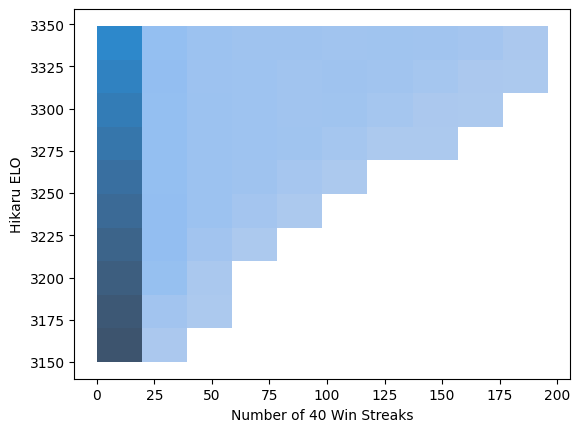

In [101]:
sns.histplot(df,x='Number of 40 Win Streaks',y='Hikaru ELO',bins=10)
plt.savefig('Number of Streaks By ELO Difference')

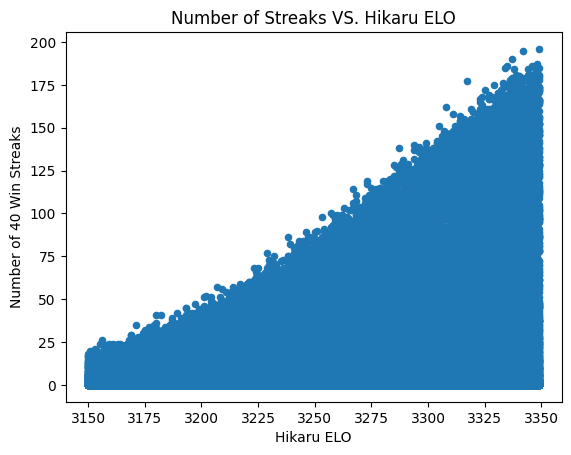

In [102]:
df[['Hikaru ELO','Number of 40 Win Streaks']].plot(
        x='Hikaru ELO',
        y='Number of 40 Win Streaks',
        kind='scatter',
        title='Number of Streaks VS. Hikaru ELO')
plt.savefig('Number of Streaks VS Hikaru ELO')

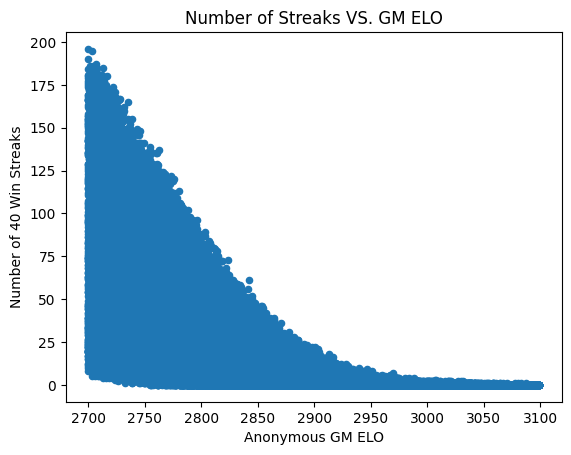

In [103]:
df[['Anonymous GM ELO','Number of 40 Win Streaks']].plot(
        x='Anonymous GM ELO',
        y='Number of 40 Win Streaks',
        kind='scatter',
        title='Number of Streaks VS. GM ELO')
plt.savefig('Number of Streaks VS GM ELO')

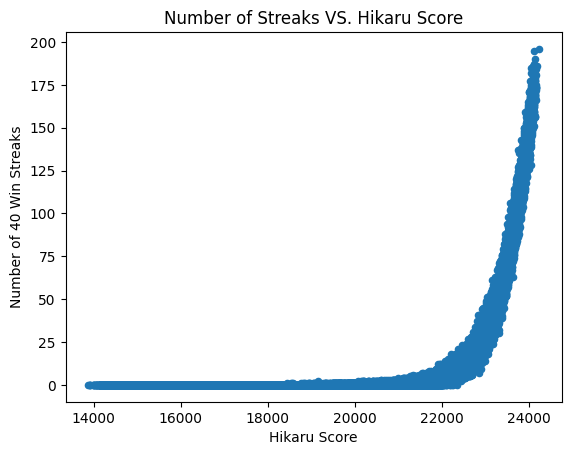

In [104]:
df[['Hikaru Score','Number of 40 Win Streaks']].plot(
        x='Hikaru Score',
        y='Number of 40 Win Streaks',
        kind='scatter',
        title='Number of Streaks VS. Hikaru Score')
plt.savefig('Number of Streaks VS Hikaru Score')

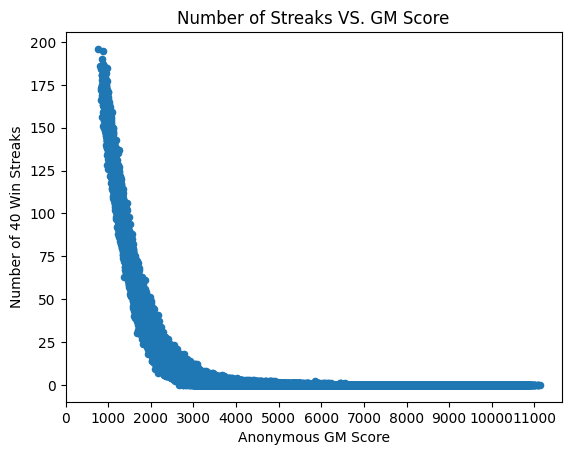

In [105]:
df[['Anonymous GM Score','Number of 40 Win Streaks']].plot(
        x='Anonymous GM Score',
        y='Number of 40 Win Streaks',
        kind='scatter',
        xticks=[i for i in range(0,12000,1000)],
        title='Number of Streaks VS. GM Score')
plt.savefig('Number of Streaks VS GM ELO')

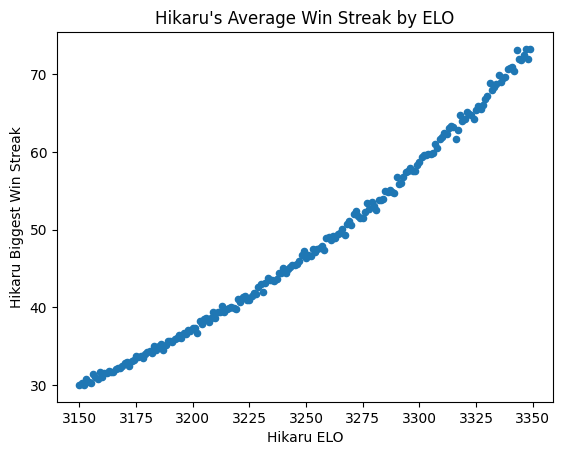

In [106]:
df.groupby('Hikaru ELO')[['Hikaru ELO','Hikaru Biggest Win Streak']].mean().plot(
        x='Hikaru ELO',
        y='Hikaru Biggest Win Streak',
        kind='scatter',
        title="Hikaru's Average Win Streak by ELO")
plt.savefig('Hikaru Average Win Streak by ELO')

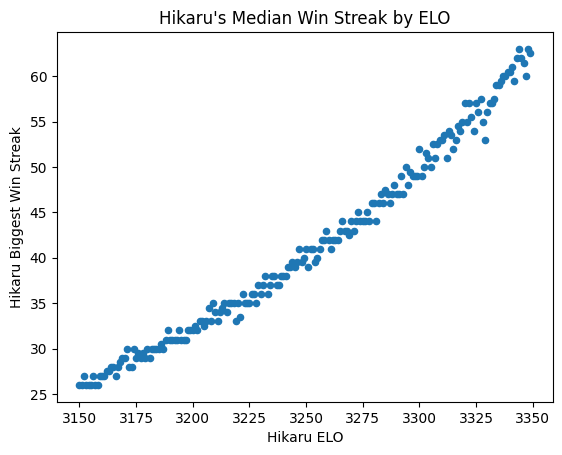

In [107]:
df.groupby('Hikaru ELO')[['Hikaru ELO','Hikaru Biggest Win Streak']].median().plot(
        x='Hikaru ELO',
        y='Hikaru Biggest Win Streak',
        kind='scatter',
        title="Hikaru's Median Win Streak by ELO")
plt.savefig('Hikaru Median Win Streak by ELO')

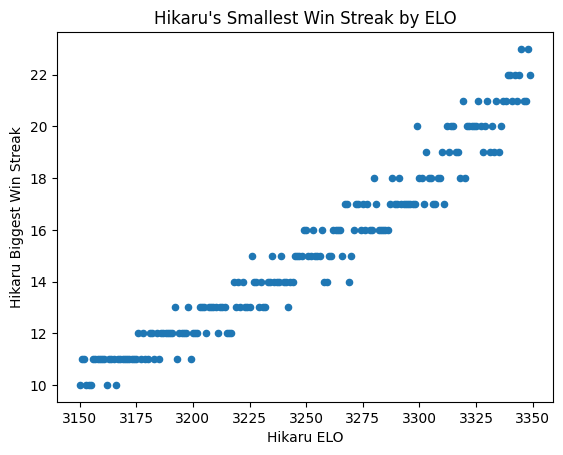

In [108]:
df.groupby('Hikaru ELO')[['Hikaru ELO','Hikaru Biggest Win Streak']].min().plot(
        x='Hikaru ELO',
        y='Hikaru Biggest Win Streak',
        kind='scatter',
        title="Hikaru's Smallest Win Streak by ELO")
plt.savefig('Hikaru Smallest Win Streak by ELO')

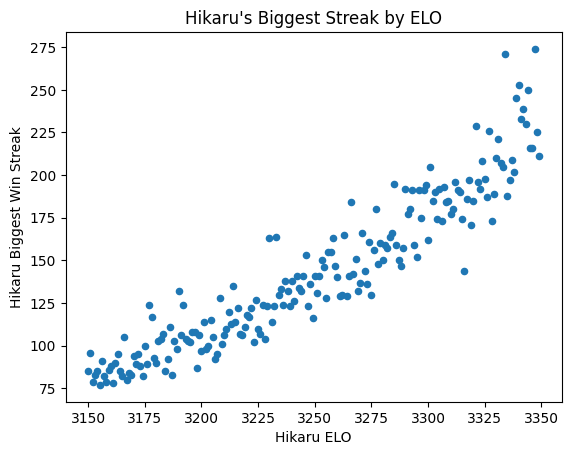

In [109]:
df.groupby('Hikaru ELO')[['Hikaru ELO','Hikaru Biggest Win Streak']].max().plot(
        x='Hikaru ELO',
        y='Hikaru Biggest Win Streak',
        kind='scatter',
        title="Hikaru's Biggest Streak by ELO")
plt.savefig('Hikaru Biggest Streak by ELO')

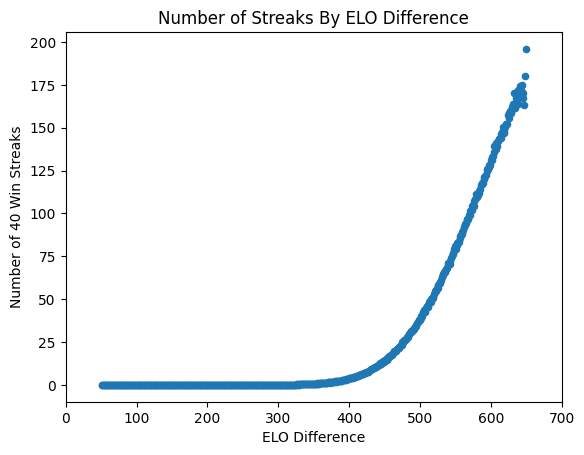

In [110]:
df.groupby('ELO Difference')[['ELO Difference','Number of 40 Win Streaks']].mean().plot(
        x='ELO Difference',
        y='Number of 40 Win Streaks',
        kind='scatter',
        xticks=[i for i in range(0,800,100)],
        title='Number of Streaks By ELO Difference')
plt.savefig('Number of Streaks By ELO Difference')

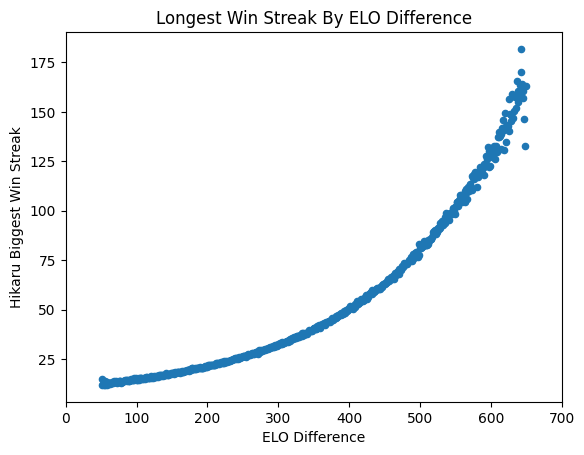

In [111]:
df.groupby('ELO Difference')[['ELO Difference','Hikaru Biggest Win Streak']].mean().plot(
        x='ELO Difference',
        y='Hikaru Biggest Win Streak',
        kind='scatter',
        xticks=[i for i in range(0,800,100)],
        title='Longest Win Streak By ELO Difference')
plt.savefig('Longest Win Streak By ELO Difference')

Based on the graphs provided, it is very evident that as Hikaru's ELO increased, the number of 40 game win streaks increases linearly. Also, as Hikaru's score increases, the expected number of 40 game win streaks increases exponentially. The larger the difference, the exponentially higher number of 40 game win streaks occurs and an exponential growth in the size of the largest winning streak.

## AI Predictions

### Splitting Data

In [ ]:
scores = []
random_state = 42

In [ ]:
features = df.drop('Number of 40 Win Streaks',axis=1)
target = df['Number of 40 Win Streaks']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features,target,test_size=0.15)

### Scaling Data

In [ ]:
scaler = StandardScaler()

In [ ]:
features_train_scaled = features_train.copy()
features_test_scaled = features_test.copy()

In [ ]:
scaler.fit(features_train_scaled)

In [ ]:
features_train_scaled = scaler.transform(features_train_scaled)
features_test_scaled = scaler.transform(features_test_scaled)

### Dummy

In [ ]:
dr = DummyRegressor(strategy="mean")
dr.fit(features_train_scaled,target_train)

In [ ]:
dr_predictions = dr.predict(features_test_scaled)

In [ ]:
scores.append(get_scores(target_test,dr_predictions))

### Logistic

In [ ]:
lr = LogisticRegression(random_state=random_state).fit(features_train_scaled,target_train)

In [ ]:
lr_predictions = lr.predict(features_test_scaled)

In [ ]:
scores.append(get_scores(target_test,lr_predictions))

### Random Forest

In [ ]:
rfr_parameters = {'random_state':[random_state],
                  'warm_start':[True,False],
                  'n_estimators':[i for i in range(50,201,50)],
                  'max_depth':[None,4,6,8],
                  'max_features':[None],
                  'min_samples_leaf':[1,3,5],
                  'verbose':[0]}

In [ ]:
rfr = GridSearchCV(RandomForestRegressor(),
                   rfr_parameters,cv=5,
                   verbose=10,
                   scoring=make_scorer(rmse)).fit(features_train_scaled,target_train)

In [ ]:
rfr_predictions = rfr.best_estimator_.predict(features_test_scaled)

In [ ]:
scores.append(get_scores(target_test,rfr_predictions))

### Cat Boost

In [ ]:
cbr_parameters = {'verbose':[0],
                  'iterations':[i for i in range(100,1001,200)],
                  'early_stopping_rounds':[1,5,10],
                  'random_state':[random_state],
                  'learning_rate':[0.0005,0.001,0.01],
                  'eval_metric':['AUC']}

In [ ]:
cbr = GridSearchCV(CatBoostRegressor(),
                   cbr_parameters,
                   scoring=make_scorer(rmse),
                   cv=5,
                   verbose=10).fit(features_train_scaled,target_train)

In [ ]:
cbr_predictions = cbr.best_estimator_.predict(features_test_scaled)

In [ ]:
scores.append(get_scores(target_test,cbr_predictions))

### Light Gradient Boost

In [ ]:
lgbm_parameters = {'verbose':[0],
                  'n_estimators':[i for i in range(50,251,50)],
                  'num_leaves':[20,31,45],
                  'max_depth':[-1,2,4,6],
                  'random_state':[random_state],
                  'learning_rate':[0.0005,0.001,0.01,0.1]}

In [ ]:
lgbm = GridSearchCV(LGBMRegressor(),
                    lgbm_parameters,
                    scoring=make_scorer(rmse),
                    cv=5,
                    verbose=10).fit(features_train_scaled,target_train)

In [ ]:
lgbm_predictions = lgbm.best_estimator_.predict(features_test_scaled)

In [ ]:
scores.append(get_scores(target_test,lgbm_predictions))

### Decision Tree

In [ ]:
dtr_parameters = {'random_state':[random_state],
                  'criterion':['squared_error','absolute_error'],
                  'max_depth':[None,2,4,6],
                  'min_samples_leaf':[1,3,5],
                  'min_samples_split':[2,3,4,5]}

In [ ]:
dtr = GridSearchCV(DecisionTreeRegressor(),
                    dtr_parameters,
                    scoring=make_scorer(rmse),
                    cv=5,
                    verbose=10).fit(features_train_scaled,target_train)

In [52]:
dtr_predictions = dtr.best_estimator_.predict(features_test_scaled)

In [53]:
scores.append(get_scores(target_test,dtr_predictions))

## AI Score Analysis

In [89]:
scores = pd.DataFrame(data=scores,columns=['Mean Squared Error','Reduced Mean Squared Error','Mean Absolute Error','Median Absolute Error','R2'],
             index=['Dummy','Logistic','Random Forest','Cat Boost','Light Gradient Boost','Decision Tree'])

In [55]:
ai_scores = pd.DataFrame(data=scores,
                         columns=['Mean Squared Error',
                                  'Reduced Mean Squared Error',
                                  'Mean Absolute Error',
                                  'Median Absolute Error','R2'],
                         index=['Dummy','Logistic','Random Forest',
                                'Cat Boost','Light Gradient Boost','Decision Tree'])

In [77]:
importances = pd.DataFrame(data=  {
                    'Dummy':[1/(len(features.columns))]*(len(features.columns)),
                    'Logistic':[1/(len(features.columns))]*(len(features.columns)),
                    'Random Forest':rfr.best_estimator_.feature_importances_,
                    'Cat Boost':cbr.best_estimator_.get_feature_importance(),
                    'Light Gradient':lgbm.best_estimator_.feature_importances_,
                    'Decision Tree':dtr.best_estimator_.feature_importances_,
                    },
             index=features.columns)

In [86]:
for col in importances.columns:
    importances[col] = importances[col]/importances[col].sum()

In [87]:
importances['Sum'] = importances['Dummy']+importances['Logistic']+importances['Random Forest']+importances['Cat Boost']+importances['Light Gradient']+importances['Decision Tree']

In [88]:
importances

,Dummy,Logistic,Random Forest,Cat Boost,Light Gradient,Decision Tree,Sum
Hikaru ELO,0.166667,0.166667,0.001683,0.001974,0.000000,0.001724,0.338714
Anonymous GM ELO,0.166667,0.166667,0.001679,0.004044,0.000000,0.001730,0.340786
Hikaru Score,0.166667,0.166667,0.445442,0.399014,0.507368,0.018628,1.703787
Anonymous GM Score,0.166667,0.166667,0.546631,0.350876,0.440000,0.973454,2.644294
Hikaru Biggest Win Streak,0.166667,0.166667,0.002973,0.007534,0.052632,0.002944,0.399416
ELO Difference,0.166667,0.166667,0.001591,0.236559,0.000000,0.001520,0.573003


In [90]:
scores

,Mean Squared Error,Reduced Mean Squared Error,Mean Absolute Error,Median Absolute Error,R2
Dummy,935.999,30.594,20.607,15.465,-0.000014
Logistic,42.243,6.499,2.738,0.000,0.954868
Random Forest,10.119,3.181,1.534,0.020,0.989189
Cat Boost,850.018,29.155,19.623,14.746,0.091847
Light Gradient Boost,890.830,29.847,20.103,15.084,0.048245
Decision Tree,18.762,4.331,2.085,0.000,0.979955
